# We first import our data

In [21]:
#We'll import in this cell the necessary libraries

import pandas as pd
import numpy as np
from scipy.stats import reciprocal

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

import re

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score , f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))




[nltk_data] Downloading package wordnet to /Users/nabil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/nabil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/nabil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# We read the train, test and sample submission data

train = pd.read_csv("train.csv" , index_col=False)
test = pd.read_csv("test.csv" , index_col=False)
submission_data = pd.read_csv("sample_submission.csv" , index_col=False)

# Data Exploration


In [5]:
train.head(10)

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...
5,306713195832307712,Politics,'Dr. Rajan: Fiscal consolidation will create m...
6,306100962337112064,Politics,"FACT: More than 800,000 defense employees will..."
7,305951758759366657,Sports,"'1st Test. Over 39: 0 runs, 1 wkt (M Wade 0, M..."
8,304482567158104065,Sports,Some of Africa's top teams will try and take a...
9,303806584964935680,Sports,'Can you beat the tweet of @RoryGribbell and z...


In [6]:
#Here we can see that there is no null values in any feature columns or the target column
print(f"Number of rows of train data is: {len(train)}\n")
train.info()


Number of rows of train data is: 6525

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6525 entries, 0 to 6524
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TweetId    6525 non-null   int64 
 1   Label      6525 non-null   object
 2   TweetText  6525 non-null   object
dtypes: int64(1), object(2)
memory usage: 153.1+ KB


In [7]:
#Now let's see how the tweets are distributed between politics and sports values
train['Label'].value_counts()

Sports      3325
Politics    3200
Name: Label, dtype: int64

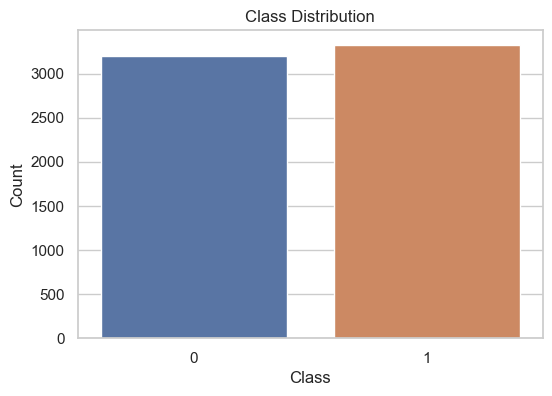

In [27]:
#Here is a bar plot that helps us see better the distribution of tweets between the two classes
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=train)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

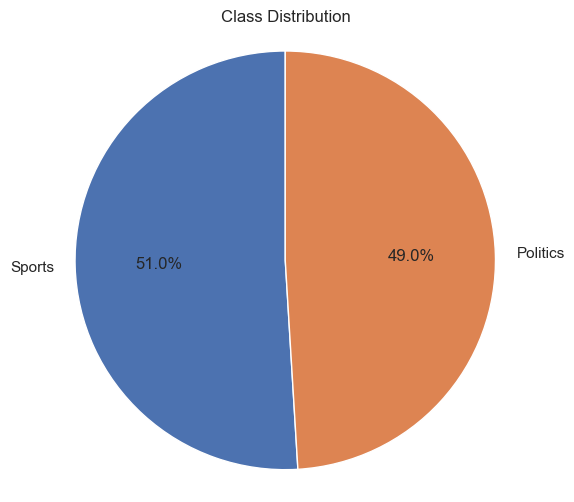

In [9]:
#A pie chart is plotted to give another visualisation, we can see that we have a balanced distribution
class_distribution = train['Label'].value_counts()


plt.figure(figsize=(6, 6))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution')
plt.axis('equal') 
plt.show()

# Data Cleaning

In [10]:
'''
We'll encode the target column and change the values of politics
and sports into 0 and 1 respectively so our models can comprehend them
'''


label_encoder = LabelEncoder()


encoded_labels = label_encoder.fit_transform(train['Label'])

# The 'encoded_labels' will now contain numerical values (0s and 1s),
# where 0 represents 'Politics' and 1 represents 'Sports'.


train['Label'] = encoded_labels
train


,TweetId,Label,TweetText
0,304271250237304833,0,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,0,'@rraina1481 I fear so'
2,303568995880144898,1,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,1,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,1,'@cricketfox Always a good thing. Thanks for t...
...,...,...,...
6520,296675082267410433,0,'Photo: PM has laid a wreath at Martyrs Monume...
6521,306677536195231746,1,'The secret of the Chennai pitch - crumbling o...
6522,306451295307431937,1,@alinabhutto he isn't on Twitter either
6523,306088574221176832,1,'Which England player would you take out to di...


In [11]:
#We write a function that, using regex operations, removes non-ASCII, punctuations and http/www links from the text tweets

def cleaned(text):
    text = re.sub(r"\n","",text)
    text = text.lower()               #here we put all the text in lowercase        
    text = re.sub(r'[^\x00-\x7f]',r' ',text)
    text = re.sub(r'[^\w\s]','',text) 
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'\bamp\b|\brt\b', '', text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = text.replace("&", "") 
    return text




In [12]:
#We apply the lemmatization to our tweet texts by making this function below


lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    word_tokens = word_tokenize(text)  
    lemmatized_tokens = []

    for word in word_tokens:
        lemma = lemmatizer.lemmatize(word)
        lemmatized_tokens.append(lemma)

    lemmatized_text = " ".join(lemmatized_tokens)  
    return lemmatized_text

train['cleaned_tweets_text'] = train['TweetText'].apply(lambda x : lemmatize_text(x))
train['cleaned_tweets_text'] = train['cleaned_tweets_text'].apply(lambda x : cleaned(x))
train


,TweetId,Label,TweetText,cleaned_tweets_text
0,304271250237304833,0,'#SecKerry: The value of the @StateDept and @U...,seckerry the value of the statedept and u...
1,304834304222064640,0,'@rraina1481 I fear so',rraina1481 i fear so
2,303568995880144898,1,'Watch video highlights of the #wwc13 final be...,watch video highlight of the wwc13 final betw...
3,304366580664528896,1,'RT @chelscanlan: At Nitro Circus at #AlbertPa...,chelscanlan at nitro circus at albertpark ...
4,296770931098009601,1,'@cricketfox Always a good thing. Thanks for t...,cricketfox always a good thing thanks for t...
...,...,...,...,...
6520,296675082267410433,0,'Photo: PM has laid a wreath at Martyrs Monume...,photo pm ha laid a wreath at martyrs monument...
6521,306677536195231746,1,'The secret of the Chennai pitch - crumbling o...,the secret of the chennai pitch crumbling on ...
6522,306451295307431937,1,@alinabhutto he isn't on Twitter either,alinabhutto he is nt on twitter either
6523,306088574221176832,1,'Which England player would you take out to di...,which england player would you take out to din...


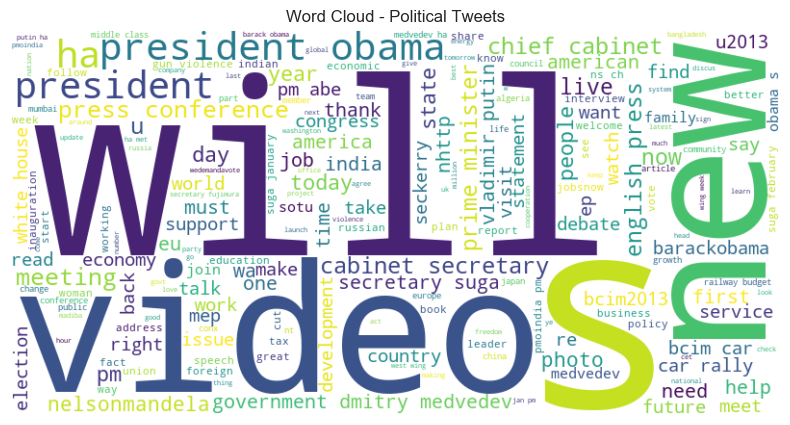

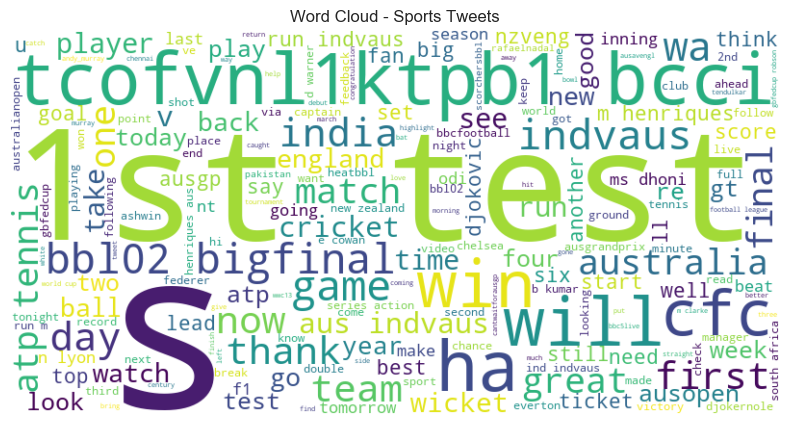

In [13]:
#We generate two world clouds, one for each label value



def generate_wordcloud(text_data, title):
    
    text_combined = ' '.join(text_data)

    
    wordcloud = WordCloud(width=800, height=400, stopwords=set(STOPWORDS),
                          background_color='white', colormap='viridis').generate(text_combined)

    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

#Politics word cloud
politic_tweets = train[train['Label'] == 0]['cleaned_tweets_text'].tolist()
generate_wordcloud(politic_tweets, title="Word Cloud - Political Tweets")

#Sports word cloud
sports_tweets = train[train['Label'] == 1]['cleaned_tweets_text'].tolist()
generate_wordcloud(sports_tweets, title="Word Cloud - Sports Tweets")


# Machine Learning modelization

In [14]:
#We create a copy as to have a backup cleaned data after fitting it into the models

train_1 = train.copy()
train_1

,TweetId,Label,TweetText,cleaned_tweets_text
0,304271250237304833,0,'#SecKerry: The value of the @StateDept and @U...,seckerry the value of the statedept and u...
1,304834304222064640,0,'@rraina1481 I fear so',rraina1481 i fear so
2,303568995880144898,1,'Watch video highlights of the #wwc13 final be...,watch video highlight of the wwc13 final betw...
3,304366580664528896,1,'RT @chelscanlan: At Nitro Circus at #AlbertPa...,chelscanlan at nitro circus at albertpark ...
4,296770931098009601,1,'@cricketfox Always a good thing. Thanks for t...,cricketfox always a good thing thanks for t...
...,...,...,...,...
6520,296675082267410433,0,'Photo: PM has laid a wreath at Martyrs Monume...,photo pm ha laid a wreath at martyrs monument...
6521,306677536195231746,1,'The secret of the Chennai pitch - crumbling o...,the secret of the chennai pitch crumbling on ...
6522,306451295307431937,1,@alinabhutto he isn't on Twitter either,alinabhutto he is nt on twitter either
6523,306088574221176832,1,'Which England player would you take out to di...,which england player would you take out to din...


In [15]:
#We define our features and labels

X = train_1['cleaned_tweets_text'].astype(str) #Here we'll only use the 'cleaned_tweets_text' column because it is the only useful feature for our use case
y = train_1['Label'].astype(float)

#The reason for converting the X and y into str and float respectively is to change their original 'object' type as seen by the info() function used above

#We split train and test data, here we'll use 20% as test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

In [16]:
#SVC
pipeline_svc = Pipeline([
    ('CVect', CountVectorizer(stop_words='english')),
    ('TfIdf', TfidfTransformer()),
    ('classifier', SVC(probability=True, kernel='rbf')),
])

#XGBoost
pipeline_xgboost = Pipeline([
    ('CVect', CountVectorizer(stop_words='english')),
    ('TfIdf', TfidfTransformer()),
    ('classifier', XGBClassifier()),
])

#LogisticRegression
pipeline_logistic = Pipeline([
    ('CVect', CountVectorizer(stop_words='english')),
    ('TfIdf', TfidfTransformer()),
    ('classifier', LogisticRegression()),
])

#LGBM
pipeline_lgb = Pipeline([
    ('CVect', CountVectorizer(stop_words='english')),
    ('TfIdf', TfidfTransformer()),
    ('classifier',LGBMClassifier()),
])


#KNN
pipeline_knn = Pipeline([
    ('CVect', CountVectorizer(stop_words='english')),
    ('TfIdf', TfidfTransformer()),
    ('classifier', KNeighborsClassifier()),
])

#RandomForest
pipeline_RF = Pipeline([
    ('CVect', CountVectorizer(stop_words='english')),
    ('TfIdf', TfidfTransformer()),
    ('classifier', RandomForestClassifier()),
])

#GradBoost
pipeline_gboost = Pipeline([
    ('CVect', CountVectorizer(stop_words='english')),
    ('TfIdf', TfidfTransformer()),
    ('classifier', GradientBoostingClassifier()),
])



In [17]:
# We test the logistic regression model on test data
pipeline_logistic.fit(X_train,y_train)
test_predictions_1 = pipeline_logistic.predict(X_test)

print(f"LogisticRegression Accuracy: {accuracy_score(y_test , test_predictions_1):.6f}" )

# We test the xgboost model on test data
pipeline_xgboost.fit(X_train,y_train)
test_predictions_2 = pipeline_xgboost.predict(X_test)

print(f"XGBClassifier Accuracy:  {accuracy_score(y_test , test_predictions_2):.6f}" )

# We test the svm classifier model on test data
pipeline_svc.fit(X_train,y_train)
test_predictions_3 = pipeline_svc.predict(X_test)

print(f"SVC Accuracy: {accuracy_score(y_test , test_predictions_3):.6f}" )

LogisticRegression Accuracy: 0.947893
XGBClassifier Accuracy:  0.894253
SVC Accuracy: 0.949425


In [18]:
# We test the Random Forest classifier model on test data
pipeline_RF.fit(X_train,y_train)
test_predictions_4 = pipeline_RF.predict(X_test)

print(f"Random Forest Accuracy: {accuracy_score(y_test , test_predictions_4):.6f}" )

# We test the gradient boosting classifier model on test data
pipeline_gboost.fit(X_train,y_train)
test_predictions_5 = pipeline_gboost.predict(X_test)

print(f"Gradient Boosting Accuracy: {accuracy_score(y_test , test_predictions_5):.6f}" )

# We test the knn classifier model on test data
pipeline_knn.fit(X_train,y_train)
test_predictions_6 = pipeline_knn.predict(X_test)

print(f"KNN Accuracy: {accuracy_score(y_test , test_predictions_6):.6f}" )

# We test the lgbm classifier model on test data
pipeline_lgb.fit(X_train,y_train)
test_predictions_7 = pipeline_lgb.predict(X_test)

print(f"LGBM Accuracy: {accuracy_score(y_test , test_predictions_7):.6f}" )

Random Forest Accuracy: 0.924904
Gradient Boosting Accuracy: 0.850575
KNN Accuracy: 0.926437
LGBM Accuracy: 0.891188


In [19]:
X_train

6283    vladimir putin ha congratulated borut pahor on...
6378                       brownbrumby     tarique_anwer 
4568    1st test  over 88  1 run  n lyon 10  m henriqu...
2398      we have a sense of humour because we feel it...
4669    oldham striker matt smith   it s disappointing...
                              ...                        
3772    video in english  press conference by chief ca...
5191    this wa the scene at wembley ahead of the  cap...
5226      the biggest threat to democracy  socioeconom...
5390    dr  raghuram rajan  chief economic advisor  ce...
860     women coconut pollinator scale new height http...
Name: cleaned_tweets_text, Length: 5220, dtype: object

In [23]:
#Now we see that SVC is the best model in this use case, we'll do some hyperparameters tuning to try to get some better accuracy

count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_count)

X_train_tfidf_dense = X_train_tfidf.toarray()

feature_names = count_vectorizer.get_feature_names_out()

train_df = pd.DataFrame(X_train_tfidf_dense, columns=feature_names)

svc_classifier = SVC()

#We'll tune these hyperparameters
param_dist = {
    'C': reciprocal(0.1, 10),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': reciprocal(0.01, 1.0)
}


random_search = RandomizedSearchCV(svc_classifier, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1)
random_search.fit(train_df, y_train)


best_params = random_search.best_params_

print("Best Hyperparameters:")
print(best_params)


best_svc_classifier = SVC(**best_params)
best_svc_classifier.fit(X_train, y_train)


optimal_prediction = best_svc_classifier.predict(X_test)


KeyboardInterrupt: 

# We apply the trained model into the test set

In [280]:
test

,TweetId,TweetText
0,306486520121012224,'28. The home side threaten again through Maso...
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....
2,289531046037438464,'@Sochi2014 construction along the shores of t...
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...
...,...,...
2605,282023761044189184,'Qualifier 1 and Eliminator games will be play...
2606,303879735006601216,"@reesedward Hi Edward, it's not a #peacekeepin..."
2607,297956846046703616,'Perera was @SunRisersIPL first #IPL purchase ...
2608,304265049537658880,"'#SecKerry: Thanks to Senator @TimKaine, @RepR..."


In [281]:
#To remove the stop words we'll have to create a function for that, we didnt use it in the train data because the CountVectorizer did that for us with the parameter 'stop_words'

def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.casefold() not in stop_words]
    return " ".join(filtered_text)

In [282]:
test['cleaned_tweets_text'] = test['TweetText'].apply(lambda x : lemmatize_text(x))
test['cleaned_tweets_text'] = test['cleaned_tweets_text'].apply(lambda x : cleaned(x))
test['cleaned_tweets_text'] = test['cleaned_tweets_text'].apply(lambda x : remove_stopwords(x))


test

,TweetId,TweetText,cleaned_tweets_text
0,306486520121012224,'28. The home side threaten again through Maso...,28 home side threaten mason bennett get end lo...
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....,mrbrown aulia thx asking see http tcoygjepjkf ...
2,289531046037438464,'@Sochi2014 construction along the shores of t...,sochi2014 construction along shore black sea h...
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...,seckerryu2019s remark meeting foreign minister...
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...,iplauction ha begun ricky ponting first player...
...,...,...,...
2605,282023761044189184,'Qualifier 1 and Eliminator games will be play...,qualifier 1 eliminator game played chidambaram...
2606,303879735006601216,"@reesedward Hi Edward, it's not a #peacekeepin...",reesedward hi edward peacekeeping mission guin...
2607,297956846046703616,'Perera was @SunRisersIPL first #IPL purchase ...,perera wa sunrisersipl first ipl purchase ipla...
2608,304265049537658880,"'#SecKerry: Thanks to Senator @TimKaine, @RepR...",seckerry thanks senator timkaine reproberthurt...


In [286]:
predictions = pipeline_svc.predict(test.cleaned_tweets_text.astype(str))

test['Predicted_Label'] = predictions


test['Predicted_Label'] = test['Predicted_Label'].replace({0: 'Politics', 1: 'Sports'})


test

,TweetId,TweetText,cleaned_tweets_text,Predicted_Label
0,306486520121012224,'28. The home side threaten again through Maso...,28 home side threaten mason bennett get end lo...,Sports
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....,mrbrown aulia thx asking see http tcoygjepjkf ...,Sports
2,289531046037438464,'@Sochi2014 construction along the shores of t...,sochi2014 construction along shore black sea h...,Politics
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...,seckerryu2019s remark meeting foreign minister...,Politics
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...,iplauction ha begun ricky ponting first player...,Sports
...,...,...,...,...
2605,282023761044189184,'Qualifier 1 and Eliminator games will be play...,qualifier 1 eliminator game played chidambaram...,Sports
2606,303879735006601216,"@reesedward Hi Edward, it's not a #peacekeepin...",reesedward hi edward peacekeeping mission guin...,Sports
2607,297956846046703616,'Perera was @SunRisersIPL first #IPL purchase ...,perera wa sunrisersipl first ipl purchase ipla...,Sports
2608,304265049537658880,"'#SecKerry: Thanks to Senator @TimKaine, @RepR...",seckerry thanks senator timkaine reproberthurt...,Politics
